Поколение 1: расстояние = 194543.5677
Поколение 2: расстояние = 193399.118
Поколение 4: расстояние = 193194.4124
Поколение 9: расстояние = 192872.5401
Поколение 12: расстояние = 192659.9793
Поколение 16: расстояние = 192458.1833
Поколение 17: расстояние = 192388.3298
Поколение 19: расстояние = 192245.8218
Поколение 20: расстояние = 192078.608
Поколение 21: расстояние = 191813.2267
Поколение 25: расстояние = 191472.7349
Поколение 36: расстояние = 191417.5131
Поколение 37: расстояние = 191295.5361
Поколение 47: расстояние = 191140.2733
Поколение 51: расстояние = 190891.4029
Поколение 55: расстояние = 190794.0934
Поколение 59: расстояние = 190701.843
Поколение 78: расстояние = 190452.862
Поколение 91: расстояние = 190257.8051
Поколение 94: расстояние = 190206.2021
Поколение 103: расстояние = 190006.9214
Поколение 173: расстояние = 189867.9737
Поколение 261: расстояние = 189756.82
Поколение 275: расстояние = 189703.4911
Поколение 310: расстояние = 189243.5843
Поколение 461: расстояние = 18

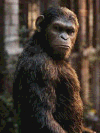

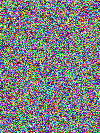

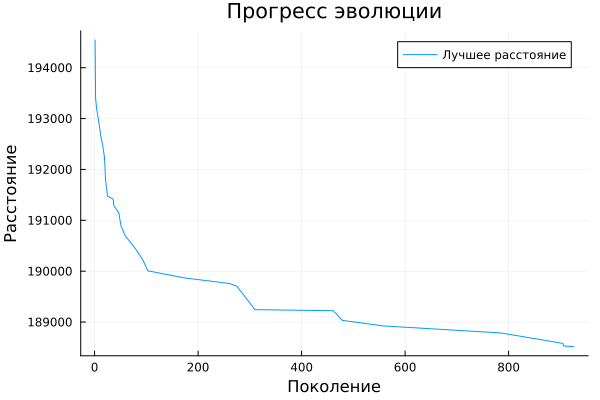

([194543.5677399795, 193399.11800988132, 193194.41240625983, 192872.54008282258, 192659.97929253496, 192458.18328145987, 192388.3297604093, 192245.82176734036, 192078.60803327372, 191813.22670764913  …  189756.82004080908, 189703.49110124464, 189243.58427698415, 189222.77437718748, 189032.45454154164, 188923.31218512976, 188785.17183031086, 188579.39779572954, 188530.08365245056, 188517.1043672165], [1, 2, 4, 9, 12, 16, 17, 19, 20, 21  …  261, 275, 310, 461, 479, 558, 785, 905, 906, 926])

In [3]:
using Images
using FileIO
using Base64
using Statistics
using ColorSchemes
using Plots

function get_12bit_palette()
    palette = Vector{RGB{Float64}}(undef, 4096)
    index = 1
    for r in 0:15 
        for g in 0:15 
            for b in 0:15
                palette[index] = RGB(r/15, g/15, b/15)
                index += 1
            end
        end
    end
    return palette
end

function image_to_matrix(img_path, palette_size=4096)
    img = load(img_path)

    img_indices = zeros(Int, size(img))
    palette = get_12bit_palette()
    

    for i in 1:size(img, 1), j in 1:size(img, 2)
        c = img[i,j]
        r, g, b = red(c), green(c), blue(c)

        r_idx = round(Int, r * 15)
        g_idx = round(Int, g * 15)
        b_idx = round(Int, b * 15)
        
        idx = r_idx * 256 + g_idx * 16 + b_idx + 1
        img_indices[i,j] = clamp(idx, 1, palette_size)
    end
    
    return img_indices
end

function matrix_to_image(matrix, palette)
    h, w = size(matrix)
    img = Array{RGB{Float64}}(undef, h, w)
    for i in 1:h, j in 1:w
        idx = clamp(matrix[i, j], 1, length(palette))
        img[i, j] = palette[idx]
    end
    return img
end

function matrix_to_binary(matrix, bits_per_element=12)
    binary_vec = Bool[]
    for elem in matrix
        val = elem - 1 
        for i in (bits_per_element-1):-1:0
            push!(binary_vec, val & (1 << i) != 0)
        end
    end
    return binary_vec
end

function binary_to_matrix(binary_vec, bits_per_element, matrix_size)
    matrix = zeros(Int, matrix_size)
    for i in 1:prod(matrix_size)
        bits = binary_vec[(i-1)*bits_per_element+1:i*bits_per_element]
        val = sum(bits[k] * (1 << (bits_per_element-k)) for k in 1:bits_per_element)
        matrix[i] = clamp(val + 1, 1, 4096)
    end
    return matrix
end

function crossover(a, b)
    n = length(a)
    child = similar(a)
    crossover_point = rand(1:n-1)
    child[1:crossover_point] = a[1:crossover_point]
    child[crossover_point+1:end] = b[crossover_point+1:end]
    return child
end

function mutate(binary_vec, mutation_rate=0.01)
    mutated = copy(binary_vec)
    for i in eachindex(mutated)
        rand() < mutation_rate && (mutated[i] = !mutated[i])
    end
    return mutated
end

function calculate_distance(a, b, use_hamming)
    if use_hamming
        return sum(a .!= b)
    else
        return sqrt(sum((a .- b).^2))
    end
end

function show_gif(frames, fps=5)
    temp_file = "evolution.gif"
    save(temp_file, cat(frames..., dims=3); fps=fps)
    println("GIF сохранен как: ", abspath(temp_file))
    return nothing
end

function run_single_experiment(target_image_path; 
                                  max_generations=500,
                                  population_size=50,
                                  mutation_rate=0.02,
                                  epsilon=0.01,
                                  tournament_size=3,
                                  use_hamming=true,
                                  show_progress=true)
    
    # Инициализация
    palette = get_12bit_palette()
    bits_per_element = 12
    reference = image_to_matrix(target_image_path, length(palette))
    matrix_size = size(reference)
    
    # Создание начальной популяции
    population = [rand(1:length(palette), matrix_size) for _ in 1:population_size]
    best_individual = copy(population[1])
    best_distance = Inf
    frames = []
    distance_history = Float64[]
    improvement_generations = Int[]
    
    # Функция для вычисления приспособленности
    fitness(individual) = calculate_distance(individual, reference, use_hamming)
    
    # Турнирный отбор
    function tournament_selection(pop, fitnesses)
        candidates = rand(1:length(pop), tournament_size)
        winner = argmin(fitnesses[candidates])
        return pop[candidates[winner]]
    end
    
    # Основной цикл
    for generation in 1:max_generations
        # Вычисление приспособленности
        fitnesses = [fitness(ind) for ind in population]
        
        # Находим лучшую особь в текущем поколении
        current_best_idx = argmin(fitnesses)
        current_best = population[current_best_idx]
        current_dist = fitnesses[current_best_idx]
        
        # Если нашли улучшение
        if current_dist < best_distance
            best_individual = copy(current_best)
            best_distance = current_dist
            push!(frames, matrix_to_image(best_individual, palette))
            push!(distance_history, best_distance)
            push!(improvement_generations, generation)
            
            # Вывод прогресса
            if show_progress
                println("Поколение $generation: расстояние = $(round(best_distance, digits=4))")
            end
        end
        
        # Проверка условия останова
        if best_distance <= epsilon
            println("\nДостигнута достаточная точность на поколении $generation")
            break
        end
        
        # Создание нового поколения
        new_population = []
        
        # Элитизм - сохраняем лучшую особь
        push!(new_population, best_individual)
        
        # Заполняем остальную часть популяции
        while length(new_population) < population_size
            # Выбор родителей
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            
            # Скрещивание и мутация
            child_bin = mutate(crossover(matrix_to_binary(parent1), 
                                        matrix_to_binary(parent2)), 
                              mutation_rate)
            
            child = binary_to_matrix(child_bin, bits_per_element, matrix_size)
            push!(new_population, child)
        end
        
        population = new_population
        
        # Проверка на случай, если не было улучшений долгое время
        if generation == max_generations
            println("\nДостигнуто максимальное число поколений")
        end
    end
    
    # Вывод результатов
    println("\n=== Результаты ===")
    println("Размер матрицы: ", matrix_size)
    println("Тип расстояния: ", use_hamming ? "Хэмминга" : "Евклидово")
    println("Размер популяции: ", population_size)
    println("Всего поколений: ", max_generations)
    println("Поколений с улучшениями: ", length(improvement_generations))
    println("Лучшее расстояние: ", round(best_distance, digits=4))
    
    # Визуализация
    println("\nЦелевое изображение:")
    display(matrix_to_image(reference, palette))
    
    println("\nФинальный результат:")
    display(matrix_to_image(best_individual, palette))
    
    if !isempty(frames)
        println("\nПроцесс эволюции (только улучшения):")
        show_gif(frames, 10)
    end
    
    # График сходимости
    if !isempty(distance_history)
        println("\nГрафик изменения расстояния:")
        plot(improvement_generations, distance_history, 
             xlabel="Поколение", ylabel="Расстояние",
             label="Лучшее расстояние", title="Прогресс эволюции")
        display(plot!())
    end
    
    return (distance_history, improvement_generations)
end

target_image = "image_100x133.jpg"
if isfile(target_image)
    run_single_experiment(target_image,
                        max_generations=1000,
                        population_size=4,
                        mutation_rate=0.1,
                        epsilon=0.01,
                        tournament_size=3,
                        use_hamming=false)
else
    println("Файл $target_image не найден!")
end